<a href="https://colab.research.google.com/github/knattarina/wildfire_challenge/blob/main/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**
*This notebook contains the data preparation of the data provided by the [IBM Call for Code Wildfire Challenge](https://community.ibm.com/community/user/datascience/blogs/susan-malaika/2020/11/10/call-for-code-spot-challenge-for-wildfires). The content is available [on GitHub](https://github.com/knattarina/wildfire_challenge).*


*   loading csv data (wildfires, weather, forecasts, landclass and vegetation index)
*   reformatting weather data one line per date
*   adding fix data to landclass
*   handle missing values in time series per region
*   handling outliers
*   merging data
*   generating new indicators






# IBM Watson related Code

In [ ]:
#from project_lib import Project
#from pyspark.sql import SparkSession

#project = Project(sc,"ff75f9c0-4f85-495d-bbc1-6305f6b1dbb8", "p-12f1b4bbd0ab3b00eacd4ce1201f20ce039b72ec")
#spark = SparkSession.builder.getOrCreate()
def get_df_watson(file_name):
    file = project.get_file(file_name)
    file.seek(0)
    return pd.read_csv(file)

def save_files_watson():
  project.save_data("Cleansed_Data.csv", aggr_df.to_csv(index=False), overwrite=True)
  project.save_data("LandClass.csv", landclass_df.to_csv(index=False), overwrite=True)
  project.save_data("Cleansed_Forecasts.csv", forecasts_df.to_csv(index=False), overwrite=True)

# Google Colab

In [ ]:
import sys
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wildfires_df = pd.read_csv('Historical_Wildfires.csv')
weather_df = pd.read_csv('HistoricalWeather.csv')
forecasts_df = pd.read_csv('HistoricalWeatherForecasts.csv')
landclass_df = pd.read_csv('LandClass.csv')
vegetation_df = pd.read_csv('VegetationIndex.csv')

forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])
wildfires_df['Date'] = pd.to_datetime(wildfires_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
vegetation_df['Date'] = pd.to_datetime(vegetation_df['Date'])

In [ ]:
##### ADD FIX DATA TO LANDCLASS #####
temp_df = pd.DataFrame.drop_duplicates(weather_df[['Region','count()[unit: km^2]']])
landclass_df = pd.merge(landclass_df, temp_df)

##### REPLACE ZEROES WITH NAN #####
#wildfires_df = wildfires_df.mask(wildfires_df==0)
wildfires_df = wildfires_df.drop(columns = ['Replaced', 'Count'])

*    Reformatting data to one line per date and region

In [ ]:
def reformat_weather_data(df):
    df = df.rename(columns={"count()[unit: km^2]": "Area", "min()": "Min", "max()": "Max", "mean()": "Mean", "variance()": "Variance"})

    # Reformat the data
    df_pivot = df.pivot_table(values=['Min','Max','Mean','Variance'], index=['Date','Region'], columns=['Parameter'])

    # Reset dataframe index
    df_pivot.reset_index(inplace=True)

    # Renaming Column names
    df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]

    # Rearranging Data and column
    params = df_pivot.columns.tolist()[3:]
    params.sort()
    
    return df_pivot[df_pivot.columns.tolist()[:3] + params].copy()

weather_df = reformat_weather_data(weather_df)
forecasts_df = reformat_weather_data(forecasts_df)

*     Handling missing values with interpolation of time series

In [ ]:
def fill_frames(df, columns):
    df_all = pd.DataFrame()
    for region in landclass_df.Region:
      df_temp = df[df['Region'] == region]
      df_temp = df_temp.resample('1D', on='Date').first().drop('Date', 1).reset_index()
      df_temp[['Region']] = df_temp[['Region']].fillna(value = region)
      df_temp[columns]=df_temp[columns].interpolate(method='linear', direction = 'backward')
      df_temp = df_temp.fillna(method='ffill')
      df_temp = df_temp.fillna(method='bfill')
      df_all = df_all.append(df_temp)
    return df_all

forecasts_df.drop_duplicates(inplace = True)
forecasts_columns = ['Precipitation_Max', 'Precipitation_Mean', 'Precipitation_Min', 'Precipitation_Variance', 'RelativeHumidity_Max', 'RelativeHumidity_Mean', 'RelativeHumidity_Min', 'RelativeHumidity_Variance', 'SolarRadiation_Max', 'SolarRadiation_Mean', 'SolarRadiation_Min', 'SolarRadiation_Variance', 'Temperature_Max', 'Temperature_Mean', 'Temperature_Min', 'Temperature_Variance', 'WindSpeed_Max', 'WindSpeed_Mean', 'WindSpeed_Min', 'WindSpeed_Variance']
forecasts_df = fill_frames(forecasts_df, forecasts_columns)

veg_columns = ['Vegetation_index_mean', 'Vegetation_index_max', 'Vegetation_index_min', 'Vegetation_index_std', 'Vegetation_index_variance']
vegetation_df = fill_frames(vegetation_df, veg_columns)

*     Merging data

In [ ]:
weather_columns = ['Precipitation_Max','Precipitation_Mean','Precipitation_Min','Precipitation_Variance','RelativeHumidity_Max','RelativeHumidity_Mean','RelativeHumidity_Min','RelativeHumidity_Variance','SoilWaterContent_Max','SoilWaterContent_Mean','SoilWaterContent_Min','SoilWaterContent_Variance','SolarRadiation_Max','SolarRadiation_Mean','SolarRadiation_Min','SolarRadiation_Variance','Temperature_Max','Temperature_Mean','Temperature_Min','Temperature_Variance', 'WindSpeed_Max','WindSpeed_Mean','WindSpeed_Min','WindSpeed_Variance']
vegetation_columns = ['Vegetation_index_mean', 'Vegetation_index_max', 'Vegetation_index_min', 'Vegetation_index_std', 'Vegetation_index_variance']
wildfire_columns = ['Estimated_fire_area', 'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power']

df_all = pd.DataFrame()
for region in landclass_df.Region:
  df_temp = wildfires_df[wildfires_df['Region'] == region]
  df_temp = df_temp.resample('1D', on='Date').first().drop('Date', 1).reset_index()

  df_date = pd.DataFrame()
  df_date['Date'] = pd.date_range('2021-01-20', periods=12, freq='D')
  df_temp = df_temp.merge(df_date, how='outer', on=['Date'])

  df_datebegin = pd.DataFrame()
  df_datebegin['Date'] = pd.date_range('2005-01-01', periods=12, freq='D')
  df_temp = df_datebegin.merge(df_temp, how='outer', on=['Date'])

  df_temp = df_temp.merge(weather_df, how='left', on=['Date', 'Region'])
  df_temp.drop(columns=['Mean_confidence', 'Std_confidence', 'Var_confidence'], inplace=True)
    
  df_temp[['Region']] = df_temp[['Region']].fillna(value = region)
  df_temp = df_temp.merge(vegetation_df, how='left', on=['Date', 'Region'])
  df_temp = df_temp.merge(landclass_df, how='left', on=['Region'])

  df_temp = df_temp.set_index(['Date','Region']).fillna(forecasts_df.set_index(['Date','Region'])).reset_index() #filling missing weather data with forecast data

  df_temp[vegetation_columns] = df_temp[vegetation_columns].fillna(method='ffill')
  df_temp[wildfire_columns] = df_temp[wildfire_columns].fillna(0)
  df_temp[weather_columns]=df_temp[weather_columns].interpolate(method='linear', direction = 'backward')
  df_temp[weather_columns]=df_temp[weather_columns].interpolate(method='linear', direction = 'backward', limit_direction ='backward')

  df_all = df_all.append(df_temp)

df_all

,Date,Region,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,SoilWaterContent_Max,SoilWaterContent_Mean,SoilWaterContent_Min,SoilWaterContent_Variance,SolarRadiation_Max,SolarRadiation_Mean,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea,count()[unit: km^2]
0,2005-01-01,NSW,0.00000,0.000000,0.0000,22.842566,2.808620,0.00000,17.383363,90.332771,57.095628,31.279930,267.158378,0.444927,0.214293,0.022578,0.009965,33.214062,22.617291,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301,0.349202,0.997200,-0.2000,0.204862,0.041968,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1,800234.348986
1,2005-01-02,NSW,0.00000,0.000000,0.0000,22.842566,2.808620,0.00000,17.383363,90.332771,57.095628,31.279930,267.158378,0.444927,0.214293,0.022578,0.009965,33.214062,22.617291,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301,0.349467,0.996555,-0.2000,0.204985,0.042019,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1,800234.348986
2,2005-01-03,NSW,0.00000,0.000000,0.0000,22.842566,2.808620,0.00000,17.383363,90.332771,57.095628,31.279930,267.158378,0.444927,0.214293,0.022578,0.009965,33.214062,22.617291,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301,0.349731,0.995910,-0.2000,0.205108,0.042070,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1,800234.348986
3,2005-01-04,NSW,8.68000,312.266667,42.4000,22.842566,2.808620,0.00000,17.383363,90.332771,57.095628,31.279930,267.158378,0.444927,0.214293,0.022578,0.009965,33.214062,22.617291,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301,0.349996,0.995264,-0.2000,0.205230,0.042121,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1,800234.348986
4,2005-01-05,NSW,16.61125,322.475000,62.3625,7.657155,0.157935,0.00000,0.273471,88.623436,47.170735,24.466665,195.639724,0.442955,0.203951,0.019950,0.009483,33.554867,28.076835,14.087289,29.763055,29.510120,22.425765,9.611800,13.352380,7.091141,4.014080,1.011328,1.043316,0.350260,0.994619,-0.2000,0.205353,0.042172,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1,800234.348986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,2021-01-27,VI,0.00000,0.000000,0.0000,11.337623,1.039285,0.00000,9.992431,91.104561,54.371662,27.333426,272.729539,0.370356,0.188192,0.000000,0.004532,31.530221,25.873258,7.298706,26.589470,28.802846,21.662305,13.189229,18.456302,8.280283,4.084100,0.934112,2.015558,0.448030,0.979500,-0.1991,0.215511,0.046445,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9,229453.176854
5871,2021-01-28,VI,0.00000,0.000000,0.0000,10.780023,2.554178,0.00000,8.544986,94.180944,58.241769,32.822820,291.777750,0.370356,0.188192,0.000000,0.004532,30.743454,24.699809,6.877093,41.580610,27.879389,22.171085,14.476383,12.891892,9.271645,4.752642,0.769428,3.315649,0.448030,0.979500,-0.1991,0.215511,0.046445,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9,229453

*     handling outliers

In [ ]:
for col in df_all.columns:
  if col in ['Estimated_fire_area','Mean_estimated_fire_radioative_power','Preciptation_Min','Preciptation_Variance','Relative_Humidity_Variance','SoilWaterContent_Min','SolarRadiation_Variance','Temperature_Variance','WindSpeed_Max','WindSpeed_Mean','WindSpeed_Variance']:
    if col in ['SoilWaterContent_Min', 'Preciptation_Max', 'Preciptation_Mean', 'Preciptation_Min', 'Preciptation_Variance']:
      scipy.stats.mstats.winsorize(df_all[col], limits = 0.10, inplace = True)
    else: 
      scipy.stats.mstats.winsorize(df_all[col], limits = 0.05, inplace = True)
    #g = sns.displot(data=aggr_df.iloc[:, :-16], x=col, hue="Region", kind="kde")

*     adding new ratios

In [ ]:
# the lower the vegetation index, the drier is the vegetation
vegetation_influenced_columns = ['Shrubs', 'Herbaceous vegetation', 'Cultivated and managed vegetation/agriculture (cropland)', 'Herbaceous wetland', 'Closed forest, deciduous broad leaf', 'Closed forest, unknown', 'Open forest, deciduous broad leaf', 'Open forest, unknown definitions']
other_landclass_columns = ['Urban / built up','Bare / sparse vegetation','Permanent water bodies','Closed forest, evergreen, broad leaf','Open forest, evergreen broad leaf','Open sea','count()[unit: km^2]']

for col in vegetation_influenced_columns:
  df_all[col+'_inflame_risk'] = df_all[col] * (1-df_all.Vegetation_index_mean)
  df_all = df_all.drop(columns = col)

df_all = df_all.drop(columns = other_landclass_columns)

In [ ]:
def segregate_date(df):
    #df["Day"] = df["Date"].dt.day
    df["Month"] = df["Date"].dt.month
    df["Year"] = df["Date"].dt.year
    return df

df_all = segregate_date(df_all)
forecasts_df = segregate_date(forecasts_df)

*     Store preprocessed data to .csv-Files

In [ ]:
df_all.to_csv('Cleansed_Data.csv', index = False)
landclass_df.to_csv('Cleansed_LandClass.csv', index = False)
forecasts_df.to_csv('Cleansed_Forecasts.csv', index = False)

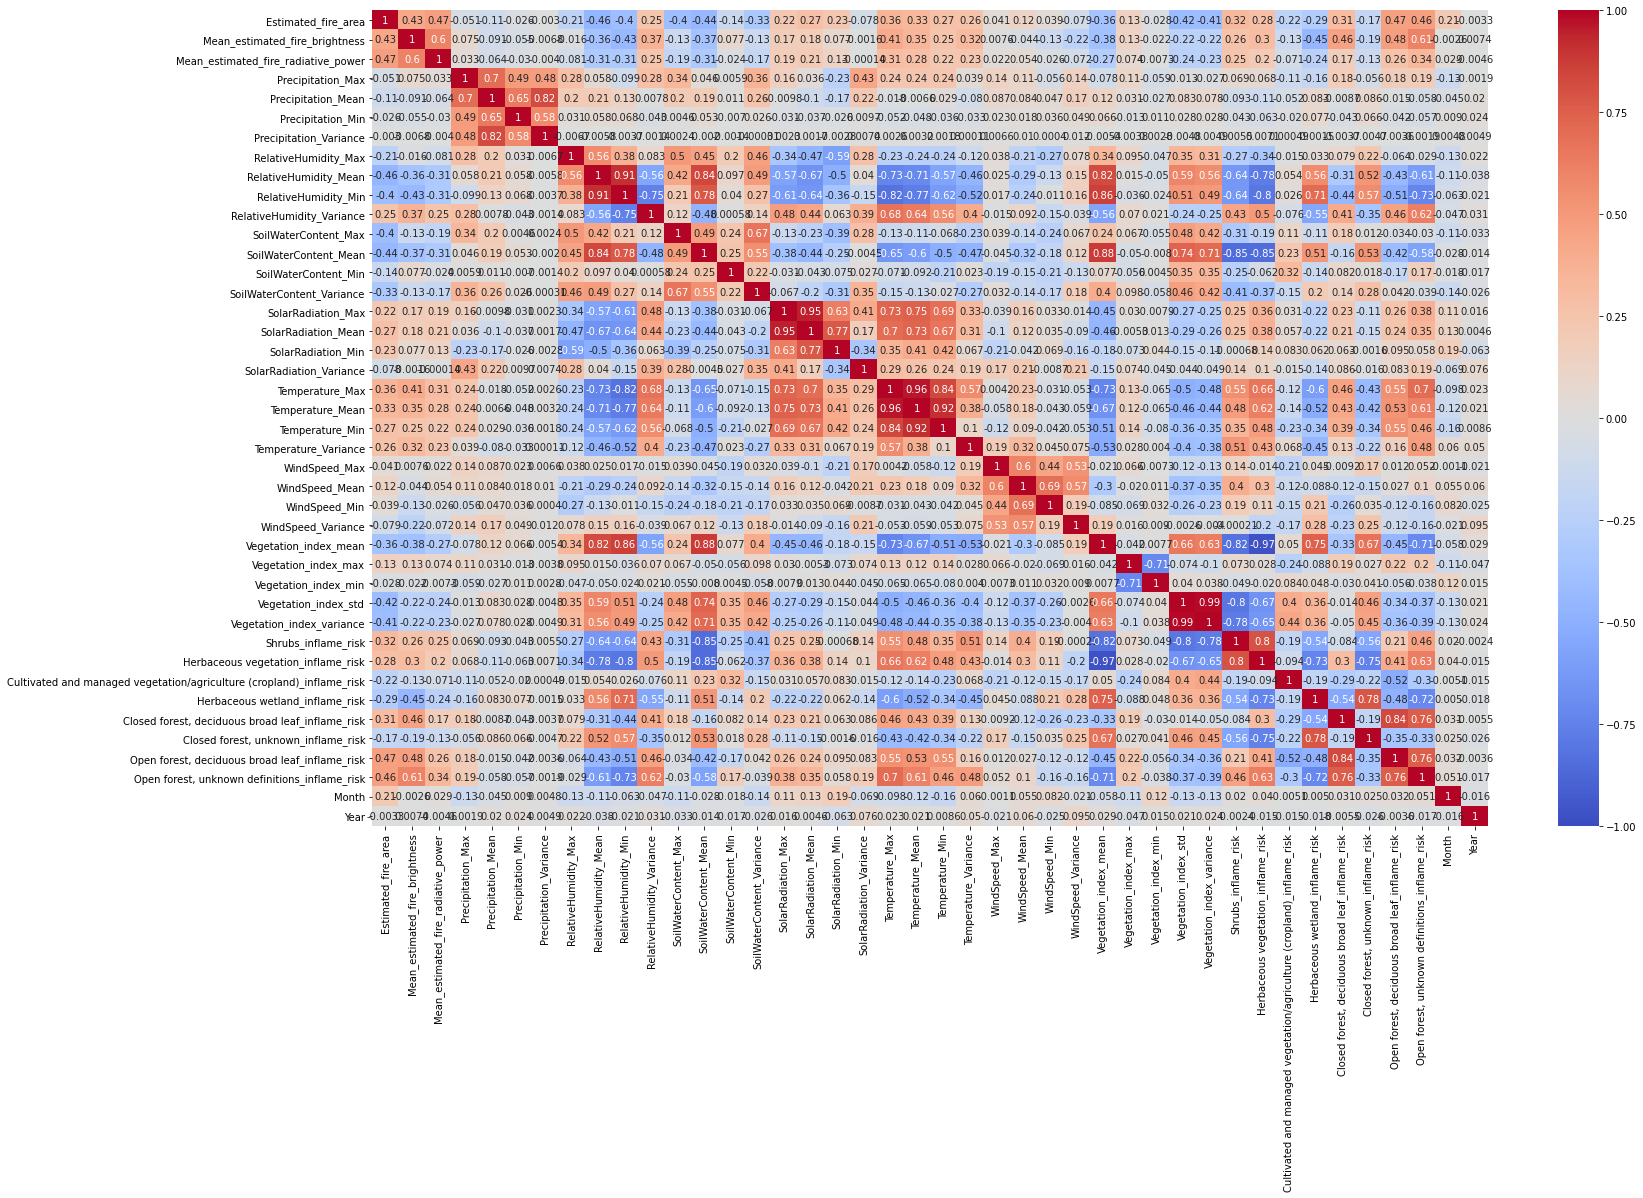

In [ ]:
##### Heat Map #####
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
corr_df = df_all.copy()
plt.figure(figsize = (25, 15))
sns.heatmap(corr_df.corr(), center = 0, cmap = "coolwarm", annot= True, vmin = -1, vmax = 1);